In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
#%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Miscellaneous code-bits and quiz tests

In [41]:
import numpy
import scipy
import pylab as plt
import sklearn
import pandas
import random

import datetime as dtm
import matplotlib.dates as mpd

import os
import sys

### "Best Trade" algorithm
- Grab some stock price data from the cloud
   - We might include a few versions of this. We have some older home-grown codes, and we'll demo the PANDAs module(s)
- We're looking for the largest forward looking difference in prices
- Walk the sequence; keep track of the running best trade and minimum price (so far), and the minimum price (so far).
- If the new price is a minimum (record-breaking low price), update. If the new price difference is a record-breaking low difference, update.


In [30]:

import matplotlib.pyplot as plt
from matplotlib import style
import pandas
#
# you might need to install pandas-datareader:
# conda install pandas-datareader
# or
# pip install pandas-datareader
import pandas_datareader.data as pdr
#


In [31]:
#qs[0:5]
#qs.index[0:5]
def get_a_best_trade(X):
    # note: if there are multiple instances of best trade, this will only get the first one. we can
    # get the last one by using a <= operator. we can get all the trades efficiently by doing a 
    # subsequent sweep through the input data for values x=x_low, x=x_high. from there, the number of
    # "best" trades is the permutation of those values.
    #
    x_min  = X[0]
    dx_max = X[1]-X[0]
    j_buy   = 0
    j_sell  = 1
    #
    for j,x in enumerate(X[1:]):
        #x_min = min(x_min, x)
        if x<x_min:
            j_buy = j
            x_min = x
        #
        dx = x - x_min
        #
        if dx>dx_max:
            j_sell  = j
            dx_max = dx
        #
    #
    # now, the efficient, c-type approach is to return just the indices of the lo,hi values;
    # the user provided the data; they can sort it out. so for now, let's just do that. we also
    # know that they must be sequential.
    #
    return (j_buy, j_sell)

In [38]:
#my_stocks = ['tsla', 'msft']
my_stock = 'msft'
start = dtm.datetime(2008,1,1)
end   = dtm.datetime.now()
#
# there are a few syntax options:
#q = pdr.get_quote_google(['AMZN', 'GOOG'] )
#
#qs = pdr.DataReader(*my_stocks, start, end)
#qs = pdr.DataReader('TSLA', "yahoo", start, end)
qs = pdr.DataReader(my_stock, "google", start, end)
#
## note that, as i recall, the yahoo engine will not account for splits, etc.
## you can get the splits, etc. from "actions" (and then i assume there is some convolving to do):
#actions = web.DataReader('AAPL', 'yahoo-actions', start, end)

In [39]:
qs.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

<IPython.core.display.Javascript object>


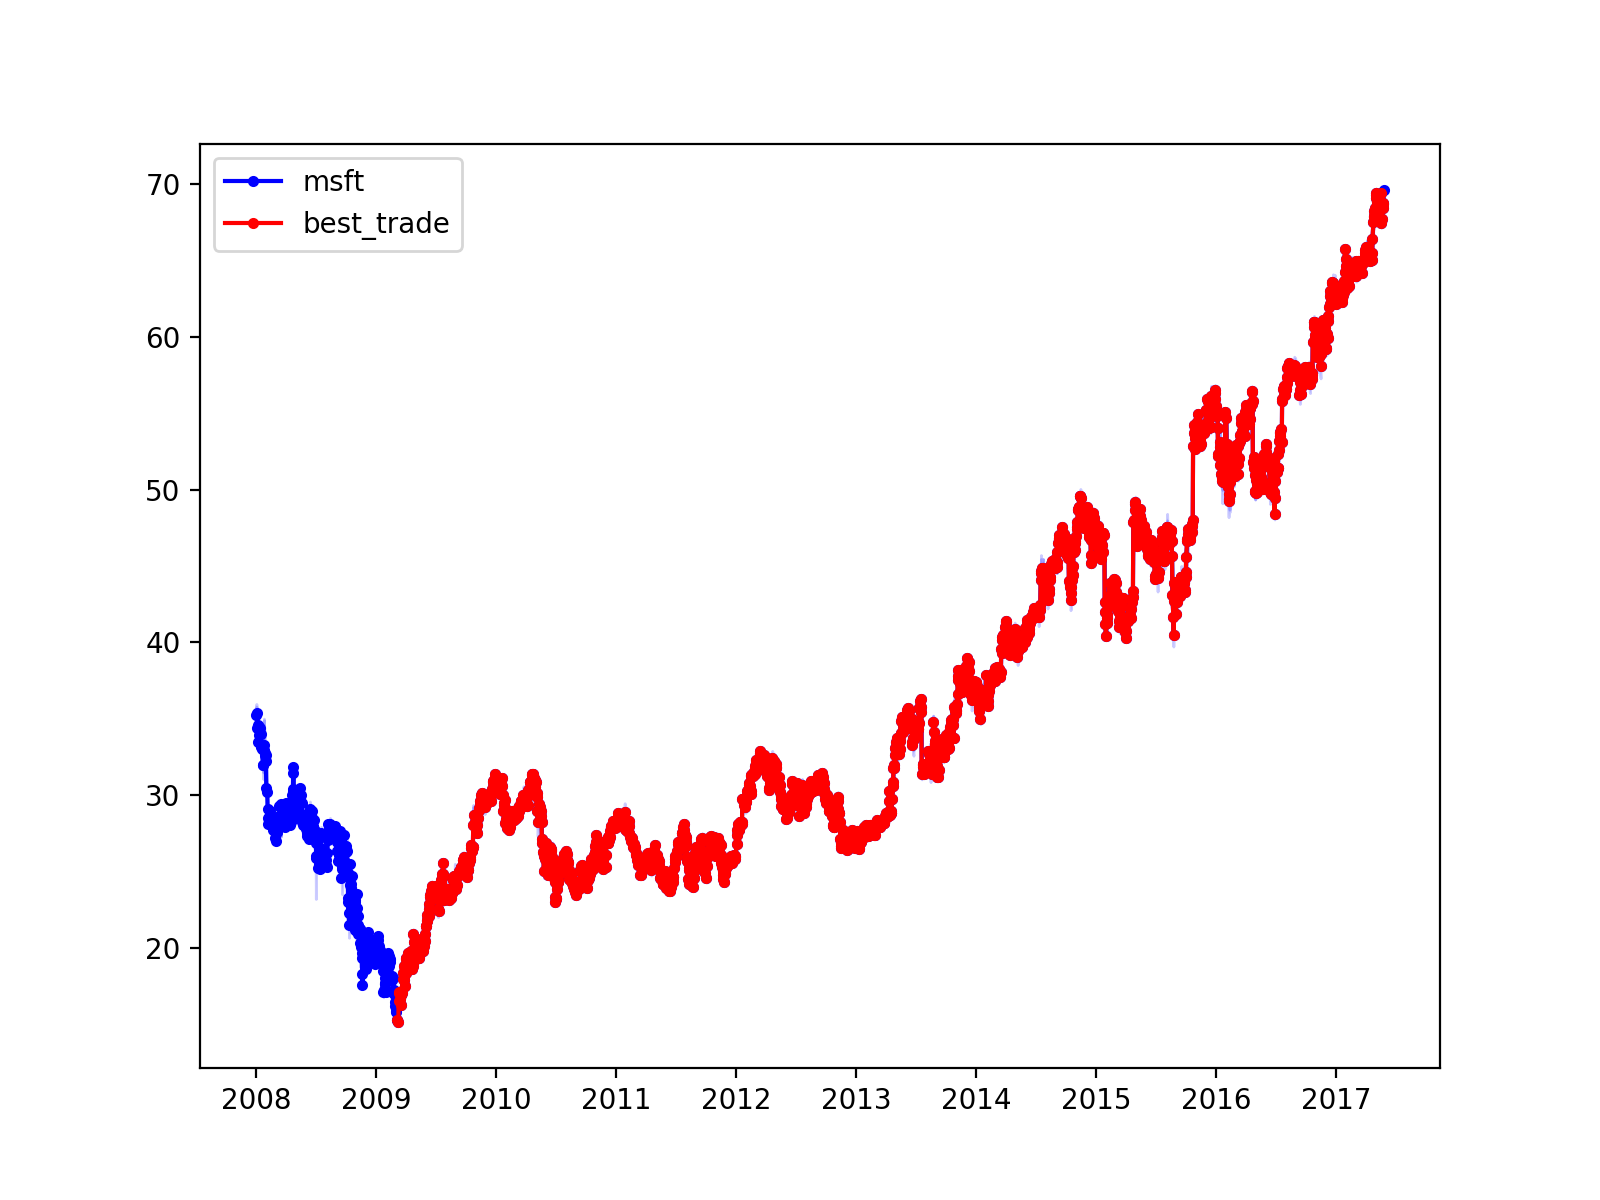

best_trade_indices:  296 2364


In [40]:
plt.figure(figsize=(8,6))
plt.clf()
#
j0,j1 = get_a_best_trade(qs.Close)
print('best_trade_indices: ', j0,j1)
#
clr = 'b'
plt.plot(qs.index, qs.Close, '.-', color=clr, label=my_stock)
plt.fill_between(qs.index, qs.High, qs.Low, color=clr, alpha=.2)
plt.fill_between(qs.index, qs.Open, qs.Close, color=clr, alpha=.2)
#
plt.plot(qs.index[j0:j1+1], qs.Close[j0:j1+1], ls='-', marker='.', color='r', label='best_trade')
#
plt.legend(loc=0)

### Phase (and generally, angle) fitter
- how do we average angles?
- we have the phase problem: 355 + 5 == 0?
- in the end, we always have a problem with non-solutions
- ... but let's try this approach:
   - For each angle, compute a unit vector
   - Compute the mean <x>, <y> values
   - Get an angle from arctan()
   - The error can be computed by propagating stdev() of <x> and <y>
   - The "goodness" can also be computed from the length of the (<x>,<y>) vector.


mean_angle:  0.357917917488


<IPython.core.display.Javascript object>


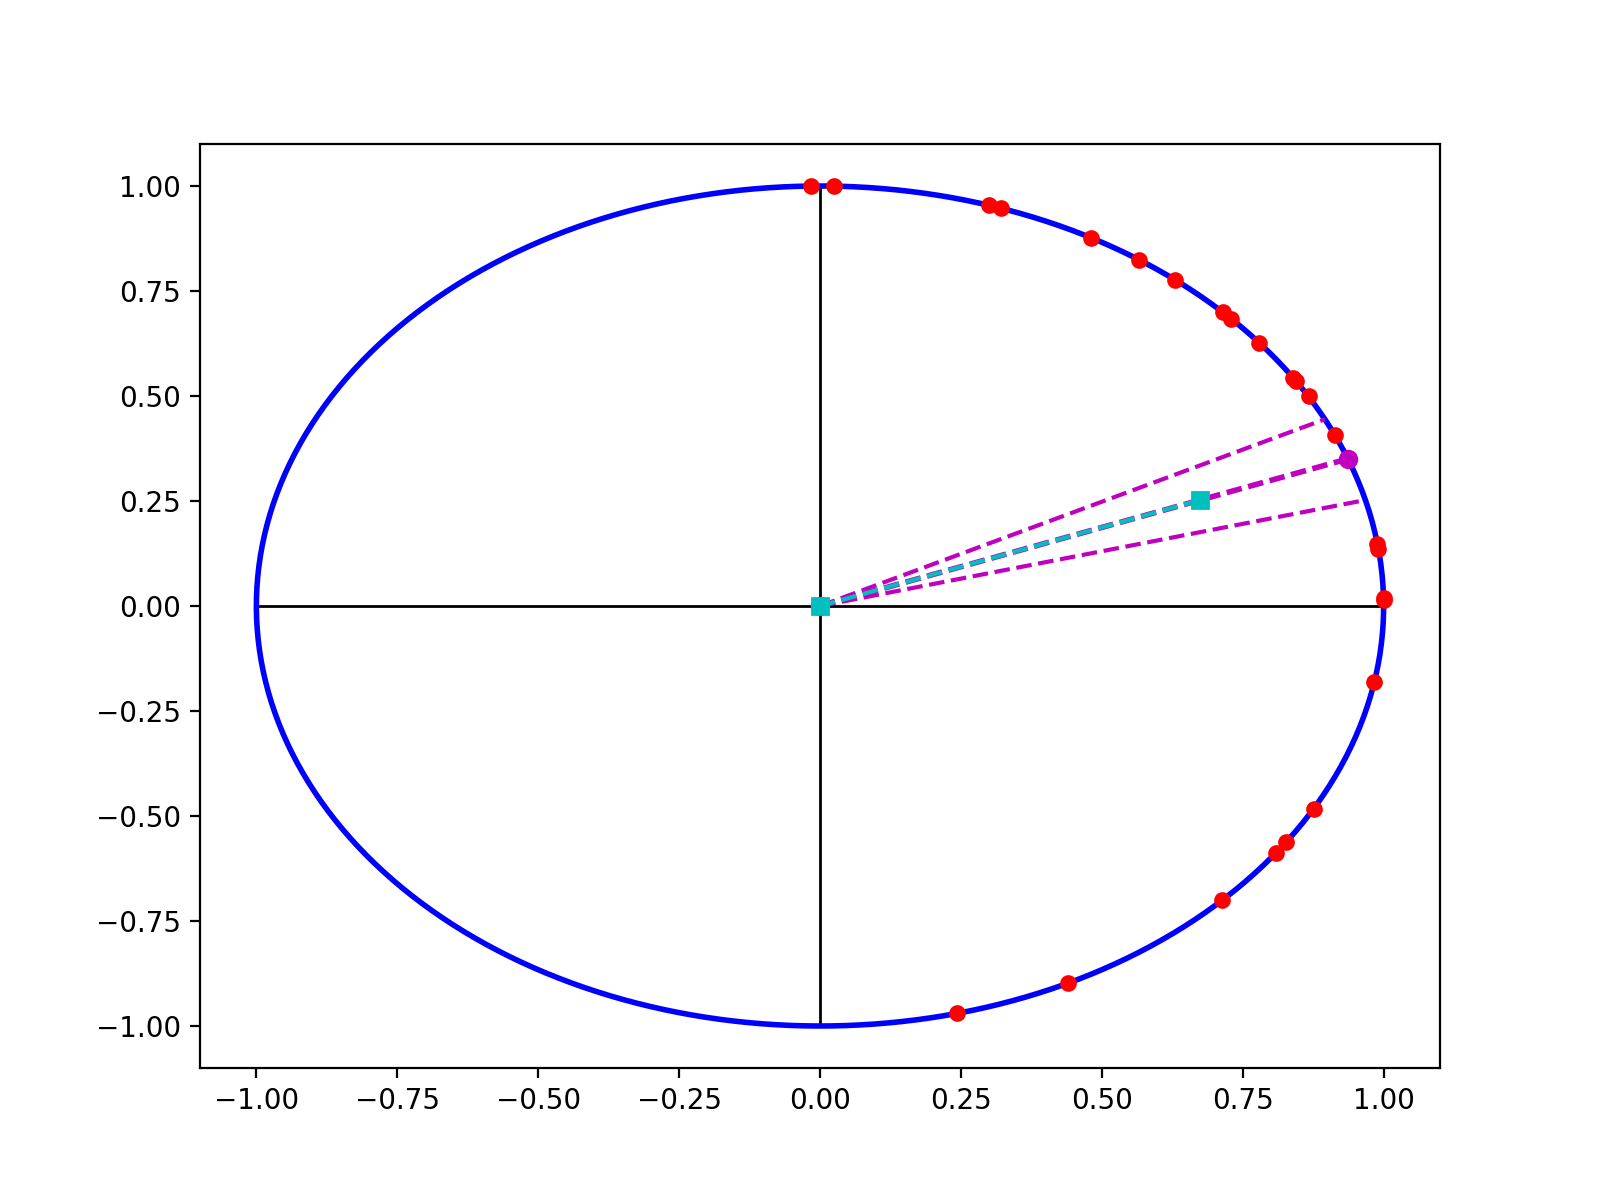

In [86]:
#class mean_angle(float):
class Mean_angle(object):
    def __init__(self, thetas):
        X,Y = numpy.cos(thetas), numpy.sin(thetas)
        x_mean = numpy.mean(X)
        y_mean = numpy.mean(Y)
        x_stdev = numpy.std(X)
        y_stdev = numpy.std(Y)
        #
        xy_mag = numpy.linalg.norm((x_mean, y_mean))
        #
        theta_mean = self.get_arctan(x=x_mean, y=y_mean)
        #
        # here is one way to compute the error, but it can give some sort of weird solutions
        # when we consider that we are interested in angles.
        dx_array = [[x_stdev, y_stdev], [x_stdev, -y_stdev],[-x_stdev, y_stdev],[-x_stdev, -y_stdev]]
        #        
        theta_hi1  = max([self.get_arctan(x=x_mean + dx, y=y_mean + dy) for dx,dy in dx_array])
        theta_lo1  = min([self.get_arctan(x=x_mean + dx, y=y_mean + dy) for dx,dy in dx_array])
        theta_err1 = abs(theta_hi1 - theta_lo1)/2.
        #
        #####
        # another approach is to use some more trig.
        # note: this is still a bit weird, and we have to be careful to keep track of the phase problem,
        # to be sure we catch the corner cases.
        y_lo      = y_mean
        x_lo      = numpy.sqrt(1. - y_mean**2.)
        theta_lo2 = numpy.arctan2(y_lo, x_lo)
        #
        # ... and we could use subtraction here, d_theat = theta_0 - theta_lo2, or we can do the complimentary
        # trig. we also know that the error is symmetric, so...
        theta_err2 = abs(theta_lo2 - theta_mean)
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
        #
    def get_mean_unit_vector(self, theta=None):
        theta = theta or self.theta_mean
        return (numpy.cos(theta), numpy.sin(theta))
    
    def get_arctan(self, x=None,y=None):
        # handle x==0 exceptions:j
        x = x or self.x_mean
        y = y or self.y_mean
        #
        #if x==0: return numpy.pi/2.
        #
        return numpy.arctan2(y, x)
#
def unit_plot_vectors(x,y=None):
    if not y is None:
        return [[0., x], [0., y]]
    else:
        return [[0., numpy.cos(x)], [0., numpy.sin(x)]]
    
# note: stick with radians, so we don't have convert
#
# make a sequence or two:
theta_0 = 3.14/9.
d_theta = 3.5
n_points = 25
R = random.Random()
#
thetas = numpy.array([theta_0 + d_theta*(R.random()-.5) for _ in range(n_points)])
#
XY = numpy.array([numpy.cos(thetas), numpy.sin(thetas)])
#
circle_xy = [(numpy.cos(x), numpy.sin(x)) for x in numpy.linspace(0, 6.282, 500)]
#
MT = Mean_angle(thetas)
print('mean_angle: ', MT.theta_mean)
#
plt.figure(figsize=(8,6))
plt.clf()
#
plt.plot([-1., 1.], [0., 0.], ls='-', lw=1., color='k', zorder=1.)
plt.plot([0.,0.], [-1., 1.], ls='-', lw=1., color='k', zorder=1.)
#
plt.plot(*zip(*circle_xy), marker='', ls='-', lw=2.0, color='b')
plt.plot(*XY, marker='.', ls='', color='r', ms=10)
#
x,y = MT.get_mean_unit_vector()
plt.plot([0.,x], [0., y], ls='--', marker='o', lw=2., color='m')
#
xy_1 = unit_plot_vectors(MT.theta_mean + MT.theta_err2)
xy_2 = unit_plot_vectors(MT.theta_mean - MT.theta_err2)
#
plt.plot(*xy_1, ls='--', marker='', color='m')
plt.plot(*xy_2, ls='--', marker='', color='m')
plt.plot(*unit_plot_vectors(MT.x_mean, MT.y_mean), ls='--', color='c', marker='s')
#
# we probably need to do a proper polygon fill, or maybe a radial plot.
#plt.fill_between(x=xy_1[0], y1=xy_1[1], y2=xy_2[1], color='m', alpha=.2)


In [70]:
print(unit_plot_vectors(MT.theta_mean + MT.theta_err2))
print(unit_plot_vectors(MT.theta_mean - MT.theta_err2))



[[0.0, 0.71557494549076839], [0.0, 0.69853596713833133]]
[[0.0, 0.71873842345172034], [0.0, 0.69528057549030919]]
